In [1]:
# note: you may need to install lightgbm manually if you run into issues with pip
# see https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html

!pip install mljar-supervised statsmodels pandas scikit-learn ipywidgets md2pdf --quiet

# alternatively, you may try installing via conda/mamba:

# !conda install mljar-supervised statsmodels pandas scikit-learn ipywidgets --quiet --y
# or
# !mamba install mljar-supervised statsmodels pandas scikit-learn ipywidgets --quiet --y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.5/271.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/

In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from supervised.automl import AutoML
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', 'The figure layout has changed to tight')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [3]:
# adapted from https://github.com/davedgd/python-class-examples/blob/main/TitanicSurvival_DescriptiveLogisticML.ipynb

TitanicSurvival = sm.datasets.get_rdataset('TitanicSurvival', 'carData', cache = True).data

Train, Test = train_test_split(TitanicSurvival,
                               stratify = TitanicSurvival.survived,
                               test_size = 0.20,
                               random_state = 345)

np.random.seed(345) # to create reproducible results

maj_class = np.where(Train.survived == 'no')[0]
min_class = np.where(Train.survived == 'yes')[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

X_train = TrainDS.drop(columns = 'survived')
y_train = TrainDS.survived.replace(['no', 'yes'], ['0', '1']).astype('int')
X_test = Test.drop(columns = 'survived')
y_test = Test.survived.replace(['no', 'yes'], ['0', '1']).astype('int')

In [4]:
# note: see results in file browser
automl = AutoML(mode = 'Explain')
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)
probabilities = automl.predict_proba(X_test)[:, 1]

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.693147 trained in 0.93 seconds
log_loss_eps() got an unexpected keyword argument 'response_method'
Problem during computing permutation importance. Skipping ...
2_DecisionTree logloss 0.495823 trained in 12.24 seconds
log_loss_eps() got an unexpected keyword argument 'response_method'
Problem during computing permutation importance. Skipping ...
3_Linear logloss 0.456719 trained in 10.57 seconds
* Step default_algorithms will try to check up to 3 models
log_loss_eps() got an unexpected keyword argument 'response_method'
Problem during computing permutation importance. Skipping ...
4_Default_Xgboost l

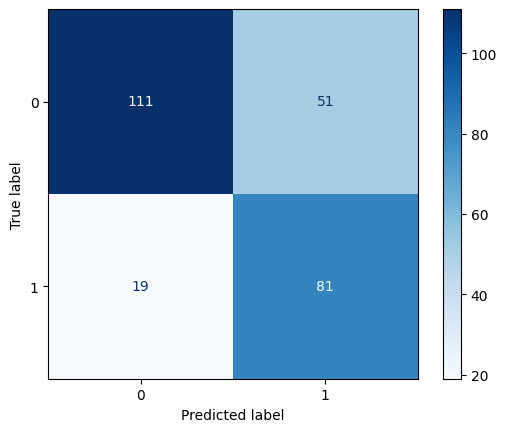

In [5]:
%matplotlib inline

ConfusionMatrixDisplay.from_predictions(y_true = y_test,
                                        y_pred = predictions,
                                        cmap = plt.cm.Blues);

In [6]:
balanced_accuracy_score(y_test, predictions).round(3)

0.748

In [7]:
roc_auc_score(y_test, probabilities).round(3)

0.834

In [8]:
# markdown to pdf report conversion (optional)
# note: you may need to refresh the file browser to see the output

result_folder = 'AutoML_1'

if 'google.colab' in str(get_ipython()):
    from md2pdf.core import md2pdf

    css = '''
    @media print{
      img {
        width: 100%;
        height: 100%;
      }

      body {
        font-size: 80%;
      }
    }
    '''

    with open("md2pdf.css", 'w') as f:
        f.write(css)

    md2pdf(pdf_file_path = './' + result_folder + '_Results.pdf',
           md_content = None,
           md_file_path = './' + result_folder + '/README.md',
           css_file_path = './md2pdf.css',
           base_url = './' + result_folder)